# Visibility Estimate With Network

In [1]:
import os
import os.path as osp
import numpy as np
import math

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from tqdm import tqdm
from einops import repeat

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

from settings import parse_args
from models import generate_model, save_ckp, load_ckp

In [2]:
def show_img(img, title="", figsize=(12,8), norm=False, inline=True):
    if inline:
        %matplotlib inline
    else:
        %matplotlib auto
    plt.figure(figsize=figsize)
    if not norm:
        plt.imshow(img)
    else:
        plt.imshow(normalize_depth_for_display(img))
    plt.title(title)
    plt.axis('off')
    plt.show()  
    
def show_tensor_img(tensor, title="", figsize=(12,8), norm=False, inline=True):
    if tensor.size()[0] == 1:
        show_img(tensor[0].detach().numpy(), title=title, figsize=(12,8), norm=False, inline=True)
    else:
        x = [tensor.detach().numpy()[i,:,:] for i in range(tensor.size()[0])]
        show_img(np.dstack(x), title=title, figsize=(12,8), norm=False, inline=True)
        
def show_data(data):
    for key in ["Scene", "FoggyScene_0.05", "DepthPerspective", "SkyMask", "t_0.05"]:
        show_tensor_img(data[key])

In [3]:
import os
import argparse
        
parser = argparse.ArgumentParser()

parser.add_argument("--model-name", default="DMRVisNet", type=str, help="model name")
parser.add_argument("--no-cuda", dest='use_cuda', action="store_false", default=True)
parser.add_argument("--resume", action="store_true", default=True, help="resume model or not")
parser.add_argument("--eps", default=1e-8, type=float, help="a small number to avoid x/0 or log(0)")

parser.add_argument("--gpu-id", default='0', type=str, help="gpu device(s) used")
parser.add_argument("--resume-name", default="final", type=str, help="resume model")
parser.add_argument("--ckp-dir", default="../checkpoints/", type=str, help="directory of checkpoint")

args = parser.parse_args(args=[])

args.resume_name = os.path.join(args.ckp_dir, args.resume_name)

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_id

# model
model = generate_model(args)
print('=> Total params: {:.2f}M'.format(sum(p.numel() for p in model.parameters()) / 1e6))
print("-"*100)

# cuda
if args.use_cuda:
    model = model.cuda()
cudnn.benchmark = True

# resume
checkpoint = load_ckp(args.resume_name)
if not checkpoint:
    raise ValueError('Failed to load checkpoint')
else:
    print("-"*100)
    pretrained_dict = checkpoint['state_dict']
    model_dict = model.state_dict()
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

# clear memory
del checkpoint, model_dict

model = model.eval()

=> create model "DMRVisNet"
=> Total params: 19.30M
----------------------------------------------------------------------------------------------------
=> load checkpoint "epoch_300_DMRVisNet.pth.tar" SUCCESS!
----------------------------------------------------------------------------------------------------


## inference

In [5]:
from torchvision import transforms
import cv2

In [6]:
img_path = "./example.jpg"
img = cv2.imread(img_path)[:,:,::-1] / 255
print(img.shape)

(500, 800, 3)


In [7]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize((288,512))])
img_tensor = trans(img.copy()).type(torch.FloatTensor).unsqueeze(0)

with torch.no_grad():
    a, t, d, defog, vis = model(img_tensor.cuda())

a = a.repeat(1, 1, 50, 50).permute(0,2,3,1).cpu().numpy()[0]
t = t.permute(0,2,3,1).cpu().numpy()[0]
d = d.permute(0,2,3,1).cpu().numpy()[0]
defog = defog.permute(0,2,3,1).cpu().numpy()[0]
vis = vis.permute(0,2,3,1).cpu().numpy()[0]

In [8]:
min_t = 1e-2
max_v = 1e5

vis_ = math.log(0.05) / (vis + 1e-8)

valid_vis = vis_[(t > min_t) & (abs(vis_) < max_v)]
if len(valid_vis) == 0:
    print("image-wise visibility: 10", )
else:
    print(f"image-wise visibility: {float(valid_vis.mean()):.3f}m", )

image-wise visibility: 74.680m


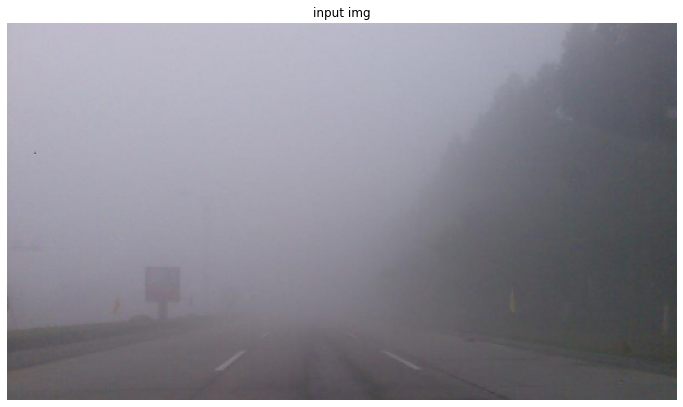

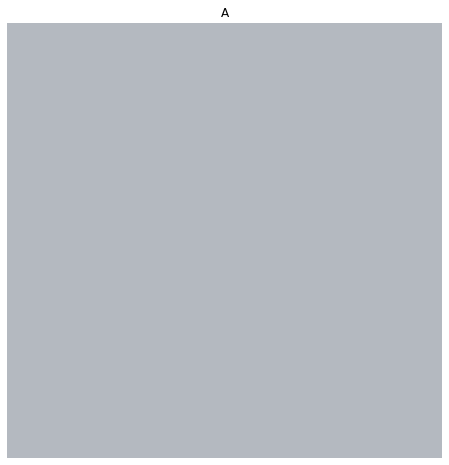

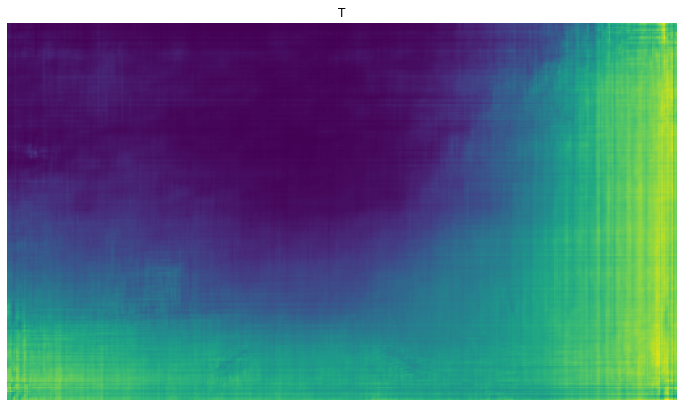

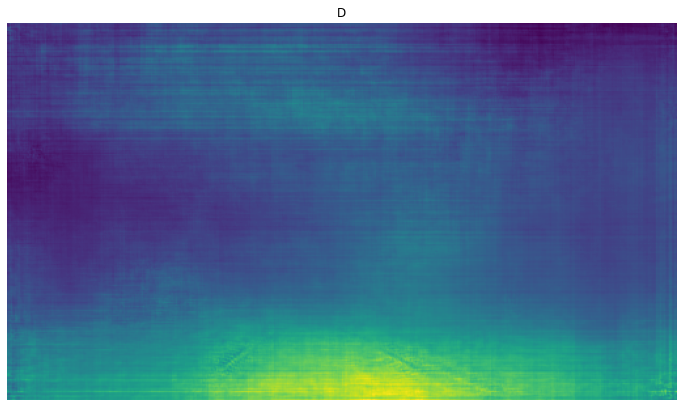

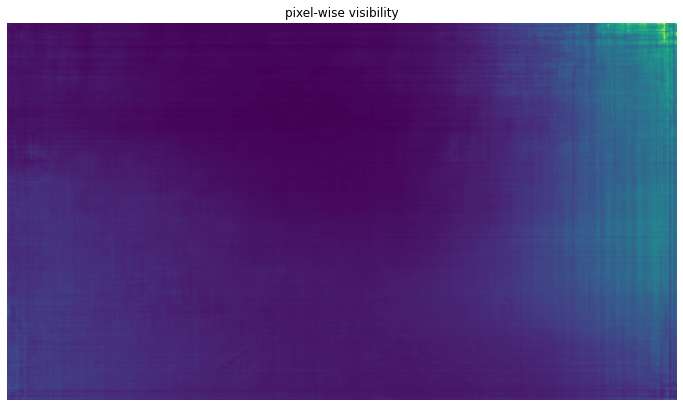

In [9]:
show_tensor_img(img_tensor[0], title="input img")
show_img(a, title="A")
show_img(t, title="T")
show_img(d, title="D")
show_img(vis_, title="pixel-wise visibility")

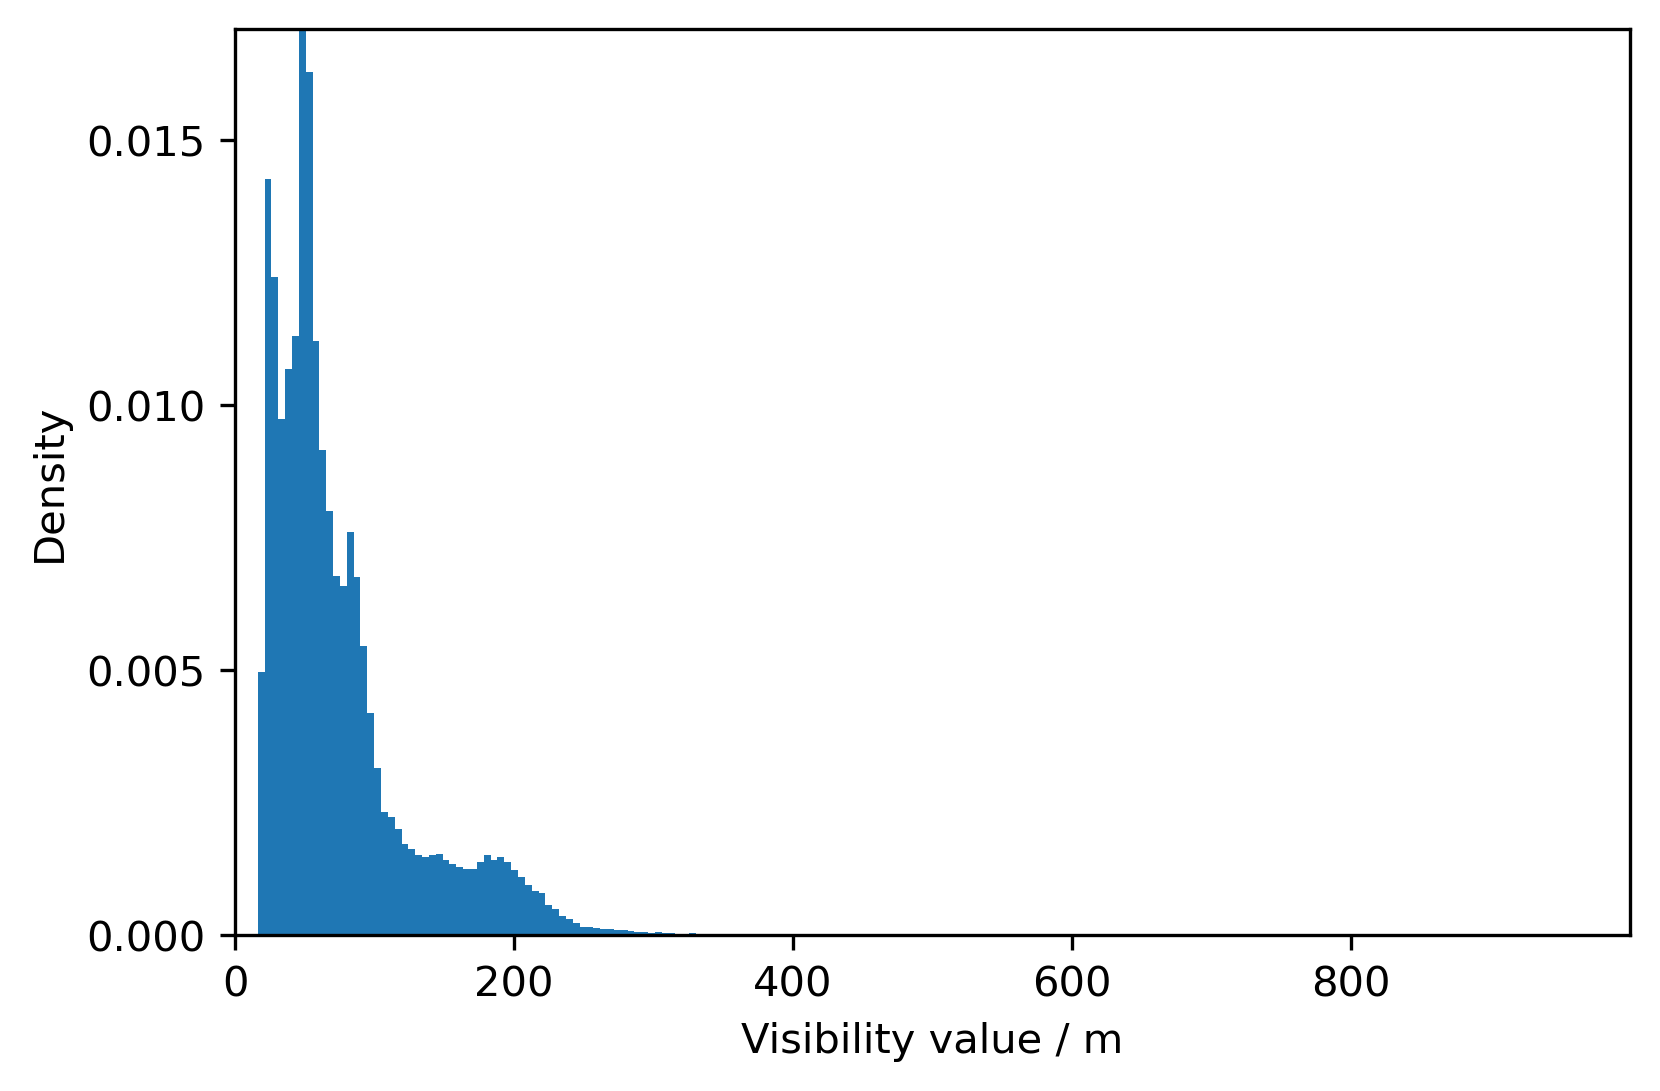

In [10]:
plt.rcParams['figure.dpi'] = 300

plt.hist(valid_vis.reshape(-1), bins=100, density=True)
plt.xlabel("Visibility value / m")
plt.ylabel("Density")

plt.xlim(0, 1000)
plt.xticks(np.arange(0,1000,200))
plt.yticks(np.arange(0,1,0.005))
plt.margins(0,0)
plt.show()